# image alignment tests


In [1]:
import cv2
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import napari
from napari import settings

from align import *

In [2]:
#folder='E:/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/Images/SEM Image/'
#folder='E:/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/Images/EDS/'
"""
folder='Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/EDS Export/'
z_scale=192
mask_size=0.7
limit=[1,79]#[18,80]
eds_x_offset = 404.8#+22
eds_y_offset = 50.8
#expected_img_count = 63
relevant_elements = ['Ca', 'Si', 'O', 'Pt', 'C']
colormaps = ["red", "green", "blue", "yellow", "magenta"]
"""

folder='Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/Images/SEM Image/' 
mask_size=0.6
z_scale=19.2
limit=[56,600]

#folder='E:/SEM Image/'
#folder='F:/2020_11_19 C3S 28d+EDX/EDS Export/'
sem_folder='F:/2020_11_19 C3S 28d+EDX/Images/SEM Image/'
#folder='D:/Avizo-Projekte/2022_01_30 CEM I 28d BIB 01-26/Images/SEM Image/'

In [3]:
folder, eds_elements = check_folder_structure(folder)

In [4]:
sem_translation, error_list, filled_canvas, loaded_images, scaling = process_translation_of_folder(folder=folder, multicore=False, do_nlm=False, mask_size=mask_size, eq_hist=True, crop_thresh=0, limit=limit )#, limit=[5,600]

loading 544 images...

trying to detect FEI scaling
SEM image saved by an FEI / thermoScientific device - probably created by FIB process
Found existing translation csv, loading...
Z:/FiB-Data/C3S + EDX/2020_11_18 C3S 28d+EDX (2 Teile)/2020_11_19 C3S 28d+EDX/Images/SEM Image/\translations.csv contains 544 lines, while 543 lines were expected
processing 544 images...
  reducing image size for translation calculations
processing image stack singlethreaded:
 processing SEM Image - SliceImage - 057.tif (1 / 544):
 processing SEM Image - SliceImage - 058.tif (2 / 544):
 processing SEM Image - SliceImage - 059.tif (3 / 544):
 processing SEM Image - SliceImage - 060.tif (4 / 544):
 processing SEM Image - SliceImage - 061.tif (5 / 544):
 processing SEM Image - SliceImage - 062.tif (6 / 544):
 processing SEM Image - SliceImage - 063.tif (7 / 544):
 processing SEM Image - SliceImage - 064.tif (8 / 544):
 processing SEM Image - SliceImage - 065.tif (9 / 544):
 processing SEM Image - SliceImage - 

In [5]:
im_cnt = len(loaded_images)
scale=(z_scale, scaling['y'], scaling['x'])

# add a shape and mark the top line of the cube

### correction of the y and x-translation

C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison!
[[ -5.15099855 745.6433512  884.        ]
 [ 23.90789461 737.02474646 884.        ]
 [ 28.1346427  719.78753697 884.        ]
 [ 34.47476485 714.40090901 884.        ]
 [ 42.39991753 714.40090901 884.        ]
 [ 49.26838318 727.32881612 884.        ]
 [ 53.49513128 728.40614172 884.        ]
 [ 55.60850533 714.40090901 884.        ]
 [ 75.68555878 703.62765308 884.        ]
 [ 80.44065039 715.4782346  884.        ]
 [118.48138325 684.23579241 884.        ]
 [122.17978783 689.62242038 884.        ]
 [126.93487944 681.00381564 884.        ]
 [132.74665807 689.62242038 884.        ]
 [142.7851848  687.46776919 884.        ]
 [147.54027641 679.92649004 884.        ]
 [152.82371153 688.54509478 884.        ]
 [168.67401689 679.92649004 884.        ]
 [177.12751308 677

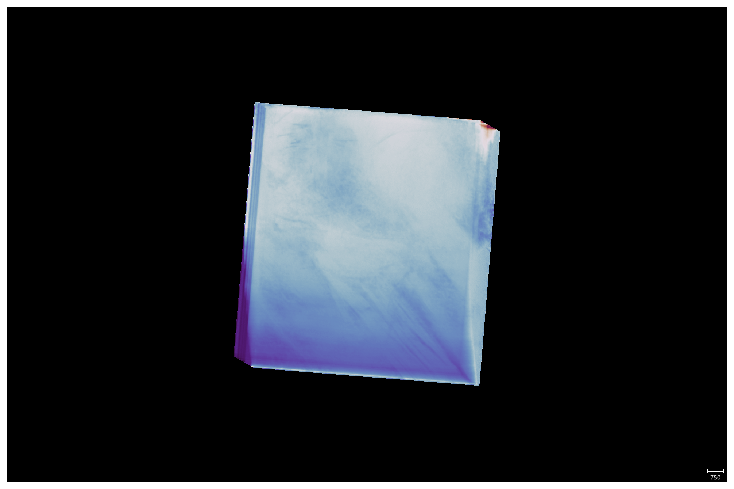

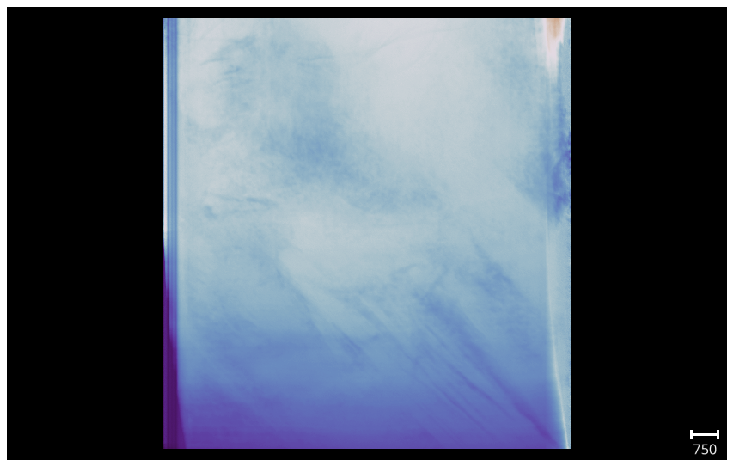

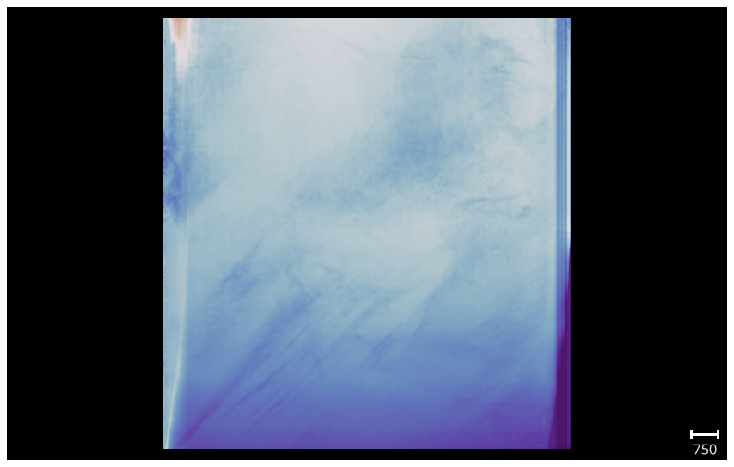

In [6]:
translation   = sem_translation.copy()
base_fn = folder + os.sep + 'translations_{}.csv'
#print(translation)
translation_csv_y    = base_fn.format('fixed_y')
translation_csv_xy   = base_fn.format('fixed_xy')
translation_manual_x = base_fn.format('manual_x')
translation_manual_y = base_fn.format('manual_y')
crop_manual          = base_fn.format('crop')


fixed_translation = load_translation_csv( translation_csv_xy, im_cnt )
final_images = None
a_list = []            
b_list = []

if len(fixed_translation) != im_cnt-1:
    #avoid the execution of following jupyter cells
    napari.settings.get_settings().application.ipy_interactive  = False
    viewer = napari.view_image(filled_canvas, name='image stack A', scale=scale)
    viewer.scale_bar.visible = True
    #viewer.add_shapes(name="select y correction line",shape_type='path', edge_width=1, edge_color='coral', face_color='royalblue', opacity=0.3)
    viewer.dims.order = (2,0,1)
    # with napari.gui_qt():
    #     viewer = napari.view_image(filled_canvas, name='select y correction line', scale=scale )
    @viewer.bind_key('y')
    def correct_y(viewer):
        global translation
        global translation_csv_y
        global translation_csv_xy
        global translation_manual_y
        print(viewer.layers['Shapes'].data[0])

        correction_dict = {}
        for point in viewer.layers['Shapes'].data[0]:
            correction_dict[math.floor(point[0])] = point[1]
        print('y', correction_dict)

        y_correction_list = get_axis_correction_list( correction_dict, im_cnt )        
        np.savetxt(translation_manual_y, np.array(y_correction_list), delimiter=",")

        for i, y in enumerate(y_correction_list):
            #print(i, y)
            #print(i, y, translation[i-1][1], translation[i-1][1] - y)
            if i>0: 
                translation[i-1][1] -= y
                #translation[i-1].append( y )
        #print(translation)
        save_translation_csv( translation, translation_csv_y )
        
        corrected_images = create_3D_stack(translation, loaded_images, False)
        viewer.add_image(corrected_images, name='image stack B', scale=scale)
        #viewer.dims.order = (1,2,0)
        viewer.layers.remove('Shapes')
        viewer.layers.remove('image stack A')

        #viewer.add_shapes(name="select x correction line", shape_type='path', edge_width=1, edge_color='red', face_color='green', opacity=0.3)

    @viewer.bind_key('x')
    def correct_x(viewer):
        global translation
        global translation_csv_xy
        global translation_manual_x
        global final_images
        #print(viewer.layers['Shapes'].data[0])

        correction_dict = {}
        for point in viewer.layers['Shapes'].data[0]:
            correction_dict[math.floor(point[0])] = point[2]
        print('x', correction_dict)

        x_correction_list = get_axis_correction_list( correction_dict, im_cnt )
        np.savetxt(translation_manual_x, np.array(x_correction_list), delimiter=",")

        for i, x in enumerate(x_correction_list):
            #print(i, x)
            #print(i, x, translation[i-1][2], translation[i-1][2] + x)
            if i>0: 
                translation[i-1][2] += x
        
        #print(translation)
        final_images = create_3D_stack(translation, loaded_images, False)
        viewer.add_image(final_images, name='Crop to Rectangle', scale=scale)
        viewer.dims.order = (0,1,2)
        viewer.layers.remove('image stack B')
        viewer.layers.remove('Shapes')
        #viewer.dims.ndisplay = 3

    @viewer.bind_key('c')
    def crop(viewer):
        global final_images
        global a_list           
        global b_list
        global crop_manual
        
        #print(viewer.layers['Shapes'].data)
        
        if len(viewer.layers['Shapes'].data[0]) == 4:
            for point in viewer.layers[1].data[0]:
                a = round(point[1])
                b = round(point[2])
                if not a in a_list: a_list.append(a)
                if not b in b_list: b_list.append(b)
        else:
            print('found less or more points than expected ({})'.format(len(viewer.layers[1].data[0])))

        a_list.sort()
        b_list.sort()
        final_images = final_images[ :, a_list[0]:a_list[1], b_list[0]:b_list[1] ]
        np.savetxt(crop_manual, np.array([a_list[0], a_list[1], b_list[0], b_list[1]]), delimiter=",")
        
        #corrected_images = create_3D_stack(translation, loaded_images, False)
        viewer.add_image(final_images, name='image stack Final', scale=scale)
        viewer.dims.order = (0,1,2)
        viewer.layers.remove('Shapes')
        viewer.layers.remove('Crop to Rectangle')
        viewer.dims.ndisplay = 3

    @viewer.bind_key('s')
    def correct_x(viewer):
        #global translation
        save_translation_csv( translation, translation_csv_xy )

        print('closing')
        viewer.close()
    
    napari.run()
    napari.settings.get_settings().application.ipy_interactive  = True
else:
    translation = fixed_translation

print(translation)

In [7]:
print(a_list)
print(b_list)

[751, 2025]
[522, 1711]


### correction of the x-translation

In [8]:
"""translation_csv = folder + os.sep + 'translations_fixed_xy.csv'
fixed_translation = load_translation_csv( translation_csv, im_cnt )
if len(fixed_translation) != im_cnt-1:
    corrected_images = create_3D_stack(translation, loaded_images, False)
    viewer = napari.view_image(corrected_images, name='select x correction line', scale=scale)
    #with napari.gui_qt():
    #    viewer = napari.view_image(corrected_images, name='select x correction line', scale=scale )
    viewer.scale_bar.visible = True
    viewer.dims.order = (1,2,0)
    correction_dict = {}
    for point in viewer.layers[1].data[0]:
        correction_dict[math.floor(point[0])] = point[0]

    x_correction_list = get_axis_correction_list( correction_dict, z_slice_count )

    for i, x in enumerate(x_correction_list):
        # print(i, y, translation[i-1][2], translation[i-1][2] - x)
        if i>0: translation[i-1][2] += x
    save_translation_csv( translation, translation_csv)

    # show final stack arrangement
    corrected_sem_images = create_3D_stack(translation, loaded_images, False)
    with napari.gui_qt():
        viewer = napari.view_image(corrected_sem_images, name='test2', scale=scale)
        viewer.scale_bar.visible = True
else:
    translation = fixed_translation"""

"translation_csv = folder + os.sep + 'translations_fixed_xy.csv'\nfixed_translation = load_translation_csv( translation_csv, im_cnt )\nif len(fixed_translation) != im_cnt-1:\n    corrected_images = create_3D_stack(translation, loaded_images, False)\n    viewer = napari.view_image(corrected_images, name='select x correction line', scale=scale)\n    #with napari.gui_qt():\n    #    viewer = napari.view_image(corrected_images, name='select x correction line', scale=scale )\n    viewer.scale_bar.visible = True\n    viewer.dims.order = (1,2,0)\n    correction_dict = {}\n    for point in viewer.layers[1].data[0]:\n        correction_dict[math.floor(point[0])] = point[0]\n\n    x_correction_list = get_axis_correction_list( correction_dict, z_slice_count )\n\n    for i, x in enumerate(x_correction_list):\n        # print(i, y, translation[i-1][2], translation[i-1][2] - x)\n        if i>0: translation[i-1][2] += x\n    save_translation_csv( translation, translation_csv)\n\n    # show final stac

In [9]:
# sadly the automatic translation did not work
"""
print(round(len(loaded_images)/3), round(len(loaded_eds_images)/3))

#1 get representative SEM image
img_sem = loaded_images[19]

#2 get same plane for a specific element EDS images
selected_element = "Pt"
folder = eds_elements[selected_element]
_, loaded_eds_images = load_image_set(folder)
img_pt  = loaded_eds_images[1]

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(1,1))
#3 get thresholded images of both images
img_sem = cv2.GaussianBlur(clahe.apply(cv2.medianBlur(img_sem, 5)), (5, 5), cv2.BORDER_DEFAULT)
img_pt  = cv2.GaussianBlur(clahe.apply(cv2.medianBlur(img_pt,  9)),  (15, 15), cv2.BORDER_DEFAULT)

#_, img_sem_bin = cv2.threshold( clahe.apply(cv2.medianBlur(img_sem, 5)) , 125, 255, cv2.THRESH_BINARY)
#_, img_pt_bin  = cv2.threshold( clahe.apply(cv2.medianBlur(img_pt,  5)) ,  60, 255, cv2.THRESH_BINARY)

col = 2
row = 1
fig=plt.figure(figsize=(col*5, row*5))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
            
plt.margins(0,0)
plt.axis('off')
fig.add_subplot(row, col, 1)

plt.axis('off')
plt.imshow(img_sem, cmap='gray')

fig.add_subplot(row, col, 2)
plt.axis('off')
plt.imshow(img_pt, cmap='gray')

mask      = None
mask_full = None

#4 get the translation of the repective images
get_image_translation('asdf', img_sem, img_pt, mask, mask_full)
"""

'\nprint(round(len(loaded_images)/3), round(len(loaded_eds_images)/3))\n\n#1 get representative SEM image\nimg_sem = loaded_images[19]\n\n#2 get same plane for a specific element EDS images\nselected_element = "Pt"\nfolder = eds_elements[selected_element]\n_, loaded_eds_images = load_image_set(folder)\nimg_pt  = loaded_eds_images[1]\n\nclahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(1,1))\n#3 get thresholded images of both images\nimg_sem = cv2.GaussianBlur(clahe.apply(cv2.medianBlur(img_sem, 5)), (5, 5), cv2.BORDER_DEFAULT)\nimg_pt  = cv2.GaussianBlur(clahe.apply(cv2.medianBlur(img_pt,  9)),  (15, 15), cv2.BORDER_DEFAULT)\n\n#_, img_sem_bin = cv2.threshold( clahe.apply(cv2.medianBlur(img_sem, 5)) , 125, 255, cv2.THRESH_BINARY)\n#_, img_pt_bin  = cv2.threshold( clahe.apply(cv2.medianBlur(img_pt,  5)) ,  60, 255, cv2.THRESH_BINARY)\n\ncol = 2\nrow = 1\nfig=plt.figure(figsize=(col*5, row*5))\nplt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, \n            hspace = 0, wsp

In [10]:
"""
def get_full_img_translation( translation, search_pos, verbose = False ):
    x_t = 0
    y_t = 0
    min_x = 0
    min_y = 0
    if verbose: print('~'*20)
    for pos, step in enumerate(translation):
        if verbose: print(pos, (step[2], step[1]), (x_t+step[2], y_t+step[1]))
        if pos <= search_pos:
            x_t += step[2]
            y_t += step[1]
        if pos==search_pos:
            if verbose: print('this translation', step)
        if min_x > step[2]: min_x = step[2]
        if min_y > step[1]: min_y = step[1]

    return (min_x, x_t), (min_y, y_t)
print( get_full_img_translation( translation, 17, True ) )
"""

"\ndef get_full_img_translation( translation, search_pos, verbose = False ):\n    x_t = 0\n    y_t = 0\n    min_x = 0\n    min_y = 0\n    if verbose: print('~'*20)\n    for pos, step in enumerate(translation):\n        if verbose: print(pos, (step[2], step[1]), (x_t+step[2], y_t+step[1]))\n        if pos <= search_pos:\n            x_t += step[2]\n            y_t += step[1]\n        if pos==search_pos:\n            if verbose: print('this translation', step)\n        if min_x > step[2]: min_x = step[2]\n        if min_y > step[1]: min_y = step[1]\n\n    return (min_x, x_t), (min_y, y_t)\nprint( get_full_img_translation( translation, 17, True ) )\n"

## load EDS images

In [11]:

def process_element(eds_elements, selected_element, se_translation,  eds_x_offset, eds_y_offset, limit=[]):
    if selected_element in eds_elements.keys():
        print('-'*20)
        print('selected element is {}'.format(selected_element))
    else:
        print('ERROR: element {} not found in the dataset'.format(selected_element))

    #eds_each_nth_slice = 10

    folder = eds_elements[selected_element]
    images, loaded_images = load_image_set(folder, limit)
    print(images)

    image_numbering = []
    for i, image in enumerate(loaded_images):
        image_numbering.append( int(images[i].split(' ')[-1].split('.')[0]) )

    #sort lists
    images = [x for _, x in sorted(zip(image_numbering, images))]
    loaded_images = [x for _, x in sorted(zip(image_numbering, loaded_images))]
    corrected_images = loaded_images
    if len(images) > 1:
        shapes = []
        shape_counts = []
        image_numbering = []
        for i, image in enumerate(loaded_images):
            shape = image.shape
            if not shape in shapes:
                shapes.append(shape)
                shape_counts.append(0)
            shape_counts[-1] +=1

        if len(shapes) > 1:
            print( ' Found multiple shapes!' )
            for i, shape in enumerate(shapes):
                print('  found {} images with this shape:'.format(shape_counts[i]), shape)

        # TODO select the indended stack?
        ignore_first_n_images = 18#shape_counts[0]-1 if len(shapes) > 1 else 0
        ignore_last_n_images = shape_counts[-2] if len(shapes) == 3 else 0
        x_offset = 0
        y_offset = 0

        # correcting position of the eds image relative to the SE images
        if ignore_first_n_images > 0:
            t_x, t_y  = get_full_img_translation(se_translation, ignore_first_n_images)
            print('  - eds x translation: {} - {} + {} '.format(eds_x_offset, t_x[0], t_x[1]))
            print('  - eds y translation: {} - {} + {} '.format(eds_y_offset, t_y[0], t_y[1] ))
            x_offset = eds_x_offset - t_x[0] + t_x[1]
            y_offset = eds_y_offset - t_y[0] + t_y[1]
            print('  - final translation {} and {}'.format( x_offset, y_offset ) )
            print( - t_y[0] + t_y[1] )

        if ignore_last_n_images == 0:
            img_stack = loaded_images[ignore_first_n_images:]
            # select images to be displayed
            selected_translation = se_translation[ignore_first_n_images-1 :]
            #selected_translation[0] = [selected_translation[0][0], selected_translation[0][1]+eds_x_offset, selected_translation[0][2]+eds_y_offset]
        else:
            loaded_images[ignore_first_n_images : ignore_last_n_images]
            # select images to be displayed
            selected_translation = se_translation[ignore_first_n_images-1 : ignore_last_n_images]
            #selected_translation[0] = [selected_translation[0][0], selected_translation[0][1]+eds_x_offset, selected_translation[0][2]+eds_y_offset]

        print(selected_translation[0])
        #selected_translation[0] = [selected_translation[0][0], -50, -10]#y_offset]
        #selected_translation[0] = [selected_translation[0][0], selected_translation[0][1]+y_offset, selected_translation[0][2]+x_offset]
        #print(selected_translation[0])

        # process eds images to reduce noise
        print(' denoising images and enhance contrast')
        for i, img in enumerate(img_stack):
            img_stack[i] = preprocess_eds_image(img)
            #_, img_stack[i] = cv2.threshold( clahe.apply(cv2.medianBlur(img, 9)) , 50, 255, cv2.THRESH_TOZERO)#THRESH_TRUNC)
            #img_stack[i] = clahe.apply(img_stack[i])

        #corrected_images = create_3D_stack(selected_translation, img_stack, do_nlm=False, first_x_offset =49, first_y_offset =471 )
        corrected_images = create_3D_stack(selected_translation, img_stack, do_nlm=False, first_x_offset=x_offset, first_y_offset=y_offset )#52 )#x_offset = 471  y_offset should be 49-52??

        cs = corrected_images.shape
        ecs = (ignore_first_n_images + cs[0] + ignore_last_n_images, cs[1], cs[2])

        if len(shapes) > 1:
            if ignore_first_n_images > 1:
                temp = np.zeros(ecs)

                if ignore_last_n_images == 0:
                    temp[ignore_first_n_images:,:,:] = corrected_images
                else:
                    temp[ignore_first_n_images:-ignore_last_n_images,:,:] = corrected_images

                corrected_images = temp

    return corrected_images

In [12]:

napari.settings.get_settings().application.ipy_interactive  = True
print(translation)
translation = load_translation_csv( translation_csv_xy, im_cnt )
print(translation)
corrected_sem_images = create_3D_stack(translation, loaded_images, False)

if len(eds_elements) > 0:

    scale=(z_scale, scaling['y'], scaling['x'])
    image_stacks = {}
    for element in eds_elements.keys():
        if element in relevant_elements:
            stack = process_element(eds_elements, element, translation, eds_x_offset, eds_y_offset, limit=limit)
            if len(stack) != len(loaded_images):
                print('Dataset for {} is incomplete ({} != {})'.format(element, len(stack), len(loaded_images)))
            else:
                image_stacks[element] = stack
        else:
            print('ignoring {}'.format(element))

    # show image stacks
    print('translate and display image stack using the following voxel dimensions: x={:.2f}, y={:.2f}, z={:.2f} {}'.format(scale[2], scale[1], scale[0], scaling['unit']))
    #scale=(z_scale*eds_each_nth_slice, x_scale/math.cos(38), x_scale)
    #with napari.gui_qt():
    viewer = napari.view_image(corrected_sem_images[ :, a_list[0]:a_list[1], b_list[0]:b_list[1] ], name='SEM images', scale=scale)#
    for i, selected_element in enumerate(image_stacks):
        print(i, selected_element)
        #new_layer = viewer.add_image(image_stacks[selected_element], name='EDS results for {}'.format(selected_element), scale=scale, colormap=colormaps[i], opacity=1, blending="additive", rendering="iso")
        new_layer = viewer.add_image(image_stacks[selected_element][ :, a_list[0]:a_list[1], b_list[0]:b_list[1] ], name='EDS results for {}'.format(selected_element), scale=scale, colormap=colormaps[i], opacity=0.5, blending="additive", rendering="mip")
    viewer.scale_bar.visible = True
    
    napari.run()
else:
    print('no elements found')

[['SEM Image - SliceImage - 057.tif', 0.0, 0.0], ['SEM Image - SliceImage - 058.tif', -1.9825367482172853, 2.2600465314105196], ['SEM Image - SliceImage - 059.tif', 0.30750330123853115, 1.3313140893739175], ['SEM Image - SliceImage - 060.tif', -0.4521392360630115, 1.2868585516222972], ['SEM Image - SliceImage - 061.tif', -0.04180262054866092, 2.4261508875923794], ['SEM Image - SliceImage - 062.tif', -10.112013822247754, -14.231326841459799], ['SEM Image - SliceImage - 063.tif', -0.801485106627217, 0.4089451561893111], ['SEM Image - SliceImage - 064.tif', 0.027699240694552683, 3.7471363264716895], ['SEM Image - SliceImage - 065.tif', 1.4201804696248355, -0.5918723107998426], ['SEM Image - SliceImage - 066.tif', -0.3955402629288147, 0.8352992237673077], ['SEM Image - SliceImage - 067.tif', -1.179769197739425, 0.5061466207931954], ['SEM Image - SliceImage - 068.tif', -0.4364229197341259, 1.1194573451891456], ['SEM Image - SliceImage - 069.tif', -0.0948608335970225, 1.172734694773467], ['S

SystemExit:   - ERROR: no translation data found!

C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:


# preprocess the raw eds images - denoising, contrast enhancing and segmentation
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))
def preprocess_sem_image(img):
    tmp = clahe.apply(cv2.medianBlur(img, 9))

    return clahe.apply( tmp )
    
for i, img in enumerate(loaded_images):
    loaded_images[i] = preprocess_sem_image(img)


# final stack arrangement
corrected_sem_images = create_3D_stack(translation, loaded_images, False)